# Credit Risk — End‑to‑End EDA → Modeling
We’re assessing default risk using **business-centric** metrics: default rate (positive class share), precision/recall for high‑risk picks, PR‑AUC for class imbalance, and top‑K capture (how many true defaults we surface in the riskiest slice). The goal: a deployable pipeline that stays **leak‑safe**, reproducible, and easy to iterate on.

## Tools
Pin core libraries for reproducibility. We’ll use scikit‑learn pipelines and lightweight plotting.

In [1]:
!pip install scikit-learn==1.7.1 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 60.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.1 which is incompatible.


## Imports
Minimal scientific stack + sklearn. Plots default to a clean theme.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, classification_report
import joblib
sns.set(style='whitegrid')

## Load dataset
Read the laotse credit risk CSV (Kaggle path). Fallback to local path if needed.

In [5]:
path = '/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv'
try:
    df = pd.read_csv(path)
except:
    df = pd.read_csv('credit_risk_dataset.csv')

In [6]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## EDA — quick visuals
We scan class balance and major drivers across numeric and categorical fields. All charts are simple, readable, and comparable across the target (0=good, 1=default).

**EDA 1 — Target distribution**

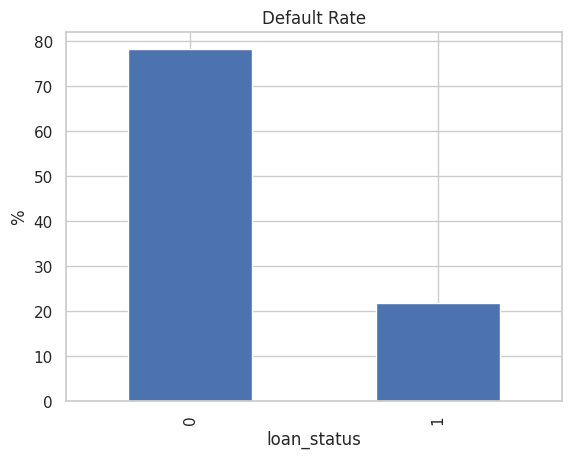

In [7]:
ax = df['loan_status'].value_counts(normalize=True).mul(100).plot.bar()
ax.set_ylabel('%'); ax.set_title('Default Rate'); plt.show()

**EDA 2 — Loan grade counts**

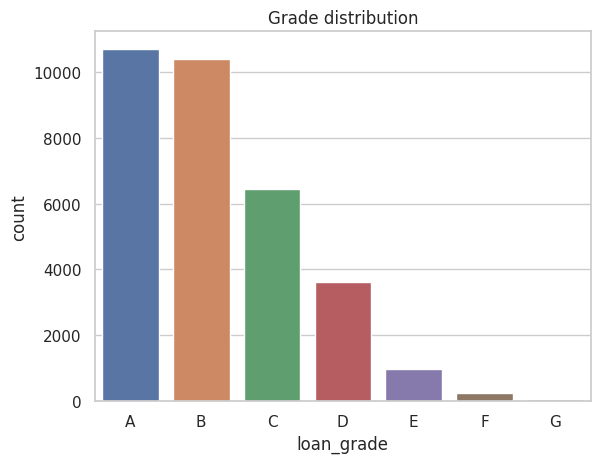

In [8]:
sns.countplot(data=df, x='loan_grade', order=sorted(df['loan_grade'].dropna().unique()))
plt.title('Grade distribution'); plt.show()

**EDA 3 — Loan intent counts**

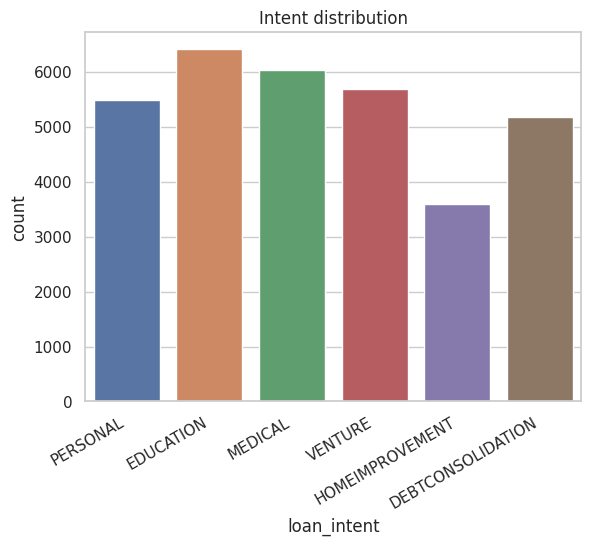

In [9]:
sns.countplot(data=df, x='loan_intent')
plt.xticks(rotation=30, ha='right')
plt.title('Intent distribution'); plt.show()

**EDA 4 — Home ownership**

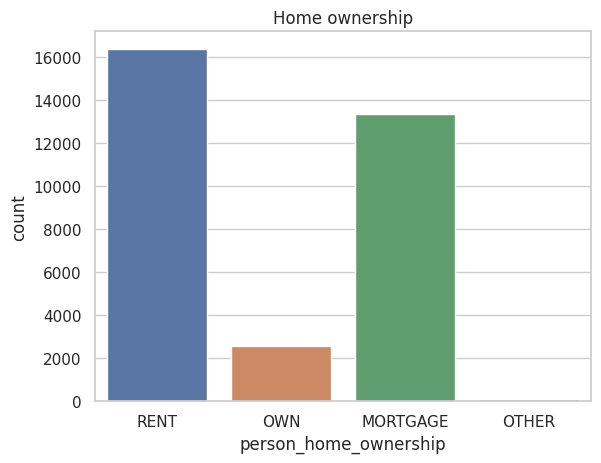

In [10]:
sns.countplot(data=df, x='person_home_ownership')
plt.title('Home ownership'); plt.show()

**EDA 5 — Loan interest rate by status**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


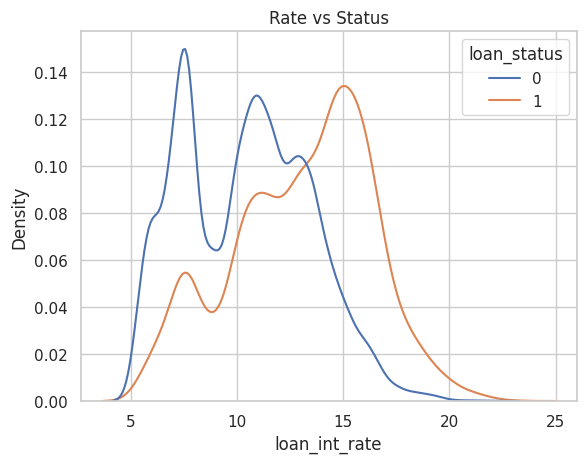

In [11]:
sns.kdeplot(data=df, x='loan_int_rate', hue='loan_status', common_norm=False)
plt.title('Rate vs Status'); plt.show()

**EDA 6 — Loan percent of income by status**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


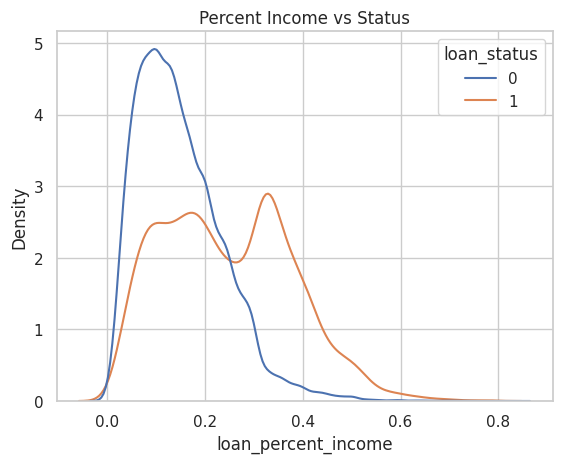

In [12]:
sns.kdeplot(data=df, x='loan_percent_income', hue='loan_status', common_norm=False)
plt.title('Percent Income vs Status'); plt.show()

**EDA 7 — Loan amount by grade**

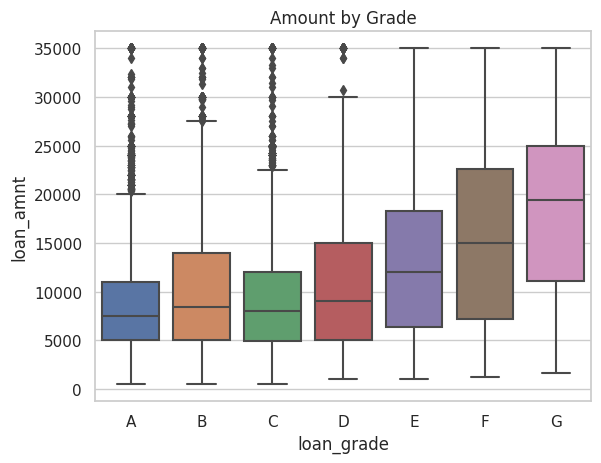

In [13]:
sns.boxplot(data=df, x='loan_grade', y='loan_amnt', order=sorted(df['loan_grade'].dropna().unique()))
plt.title('Amount by Grade'); plt.show()

**EDA 8 — Numeric correlation heatmap**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


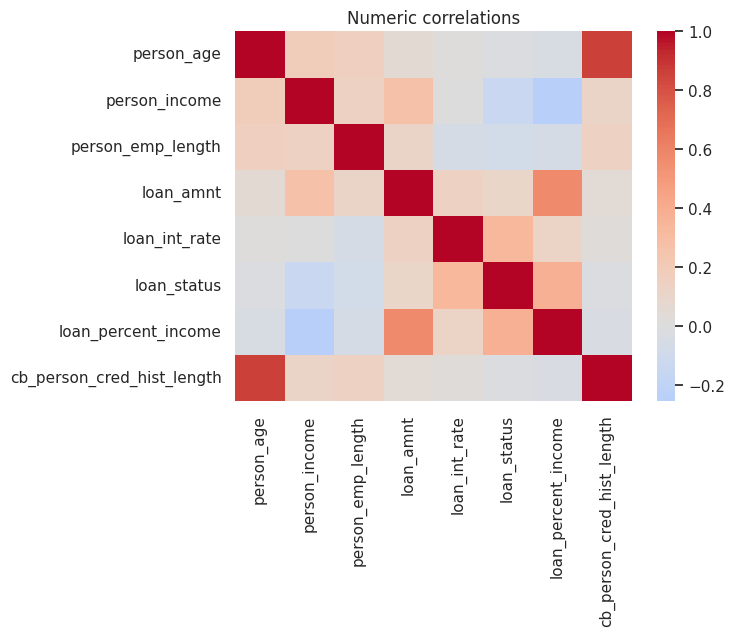

In [14]:
num = df.select_dtypes(include='number')
sns.heatmap(num.corr(), cmap='coolwarm', center=0)
plt.title('Numeric correlations'); plt.show()

**EDA 9 — Amount vs Rate by status**

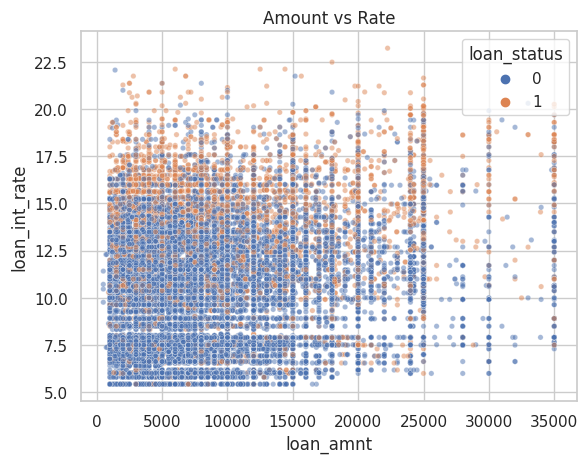

In [15]:
sns.scatterplot(data=df, x='loan_amnt', y='loan_int_rate', hue='loan_status', s=15, alpha=.5)
plt.title('Amount vs Rate'); plt.show()

**EDA 10 — Income by status (violin)**

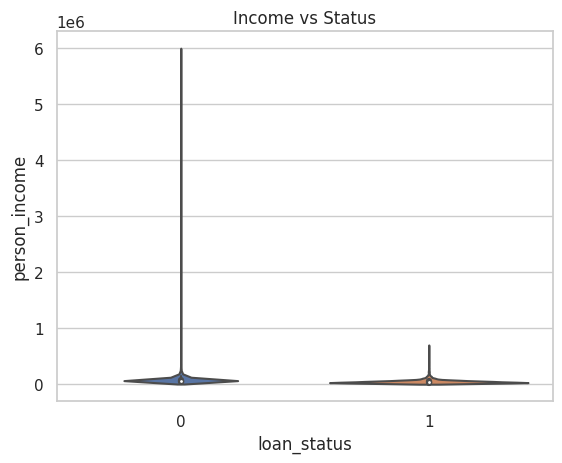

In [16]:
sns.violinplot(data=df, x='loan_status', y='person_income', cut=0)
plt.title('Income vs Status'); plt.show()

## Data preprocessing
We isolate target, define feature types, and postpone imputation/encoding to pipelines. This prevents leakage and keeps inference identical to training.

In [17]:
assert 'loan_status' in df.columns
y = df['loan_status'].astype(int)
X = df.drop(columns=['loan_status'])
print(X.shape, y.shape)

(32416, 11) (32416,)


In [18]:
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()
print(len(num_cols), len(cat_cols))

7 4


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(X_train.shape, X_test.shape)

(25932, 11) (6484, 11)


### Lightweight feature engineering
We add a few robust transforms to help linear models: logs for skew and simple ratios. All done on train/test consistently via a small pre‑FE step.

In [20]:
for c in ['person_income','loan_amnt']:
    if c in X_train:
        X_train['log_'+c] = np.log1p(X_train[c].clip(lower=0))
        X_test['log_'+c] = np.log1p(X_test[c].clip(lower=0))

In [21]:
if {'loan_amnt','person_income'}.issubset(X_train):
    X_train['loan_to_income'] = X_train['loan_amnt']/X_train['person_income'].replace(0,np.nan)
    X_test['loan_to_income'] = X_test['loan_amnt']/X_test['person_income'].replace(0,np.nan)

In [22]:
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]
print(len(num_cols), len(cat_cols))

10 4


## Model training (pipeline)
We build sklearn pipelines: imputers + encoders + model. Metrics: ROC‑AUC, PR‑AUC, confusion matrix, ROC, and PR curves.

In [23]:
num_pipe = Pipeline([('imp', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_pipe = Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])

In [24]:
preprocess = ColumnTransformer([('num', num_pipe, num_cols), ('cat', cat_pipe, cat_cols)], remainder='drop', verbose_feature_names_out=False)

In [25]:
clf = xgb.XGBClassifier(
    objective='binary:logistic',  
    eval_metric='logloss',       
    use_label_encoder=False,     
    n_jobs=-1,                   
    scale_pos_weight=1       
)

In [26]:
pipe = Pipeline([('prep', preprocess), ('clf', clf)])

In [27]:
pipe.fit(X_train, y_train)
proba = pipe.predict_proba(X_test)[:,1]
pred = (proba >= 0.5).astype(int)

### Evaluation
We report threshold‑free curves (ROC/PR) and thresholded outcomes (confusion matrix).

In [28]:
roc = roc_auc_score(y_test, proba)
pr = average_precision_score(y_test, proba)
print(round(roc,3), round(pr,3))

0.951 0.91


In [29]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5066
           1       0.96      0.74      0.84      1418

    accuracy                           0.94      6484
   macro avg       0.95      0.87      0.90      6484
weighted avg       0.94      0.94      0.93      6484



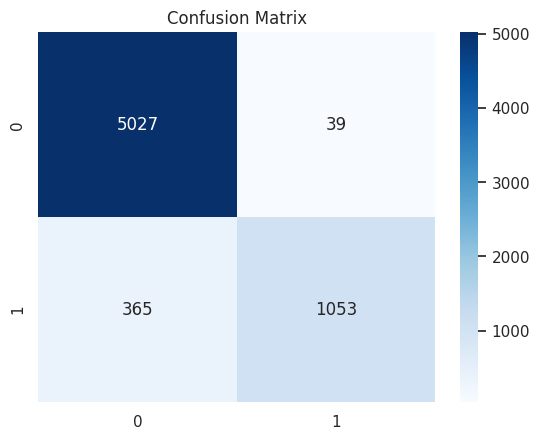

In [30]:
cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix'); plt.show()

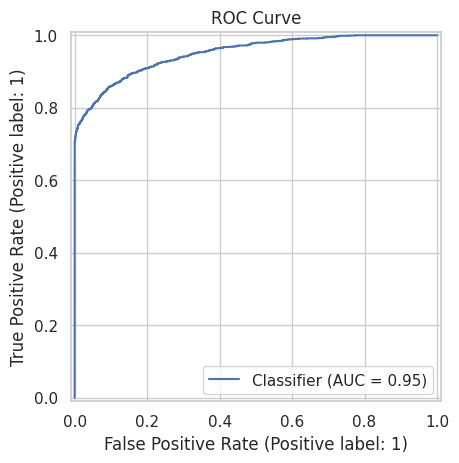

In [31]:
RocCurveDisplay.from_predictions(y_test, proba)
plt.title('ROC Curve'); plt.show()

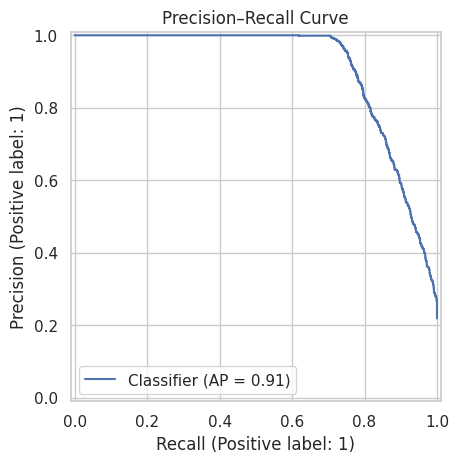

In [32]:
PrecisionRecallDisplay.from_predictions(y_test, proba)
plt.title('Precision–Recall Curve'); plt.show()

## Model saving
Persist the full pipeline (preprocess + model) for seamless reuse in production or Kaggle Inference.

In [33]:
joblib.dump(pipe, 'credit_risk_pipeline.joblib')
print('saved: credit_risk_pipeline.joblib')

saved: credit_risk_pipeline.joblib
